In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
import matplotlib.pyplot as plt


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier


from tensorflow.keras.preprocessing.image import load_img,img_to_array
import math
# !pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow import keras


In [ ]:
# import os
main_path = '/content/drive/MyDrive/breast_cancer_detection/vit_vecs/'
filelist=os.listdir(main_path)
print(filelist)
labels = [len(list(zip(os.listdir(main_path+p))))*[int(p)] for p in filelist]
labels = [item for sublist in labels for item in sublist]
filelist = [os.listdir(main_path+p) for p in filelist]
filelist = [item for sublist in filelist for item in sublist]
len(filelist), filelist[:3]
print(len(filelist), len(labels))
data = pd.DataFrame(data={'path':filelist, 'cl2':labels})
data

['1', '2', '3', '4', '5', '6', '0', '7']
7909 7909


,path,cl2
0,SOB_B_F-14-23222AB-100-006.npy,1
1,SOB_B_F-14-29960AB-400-006.npy,1
2,SOB_B_F-14-25197-40-030.npy,1
3,SOB_B_F-14-21998EF-400-001.npy,1
4,SOB_B_F-14-25197-400-051.npy,1
...,...,...
7904,SOB_B_A-14-22549AB-400-004.npy,7
7905,SOB_B_A-14-22549CD-400-023.npy,7
7906,SOB_B_A-14-22549G-100-030.npy,7
7907,SOB_B_A-14-22549AB-200-019.npy,7


In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv('/content/drive/MyDrive/breast_cancer_detection//Folds.csv')
img_dir = '/content/drive/MyDrive/breast_cancer_detection//BreaKHis_v1/'
class_names = ['benign', 'malignant']
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data
data = data.drop_duplicates(subset=['filename'],keep='first')[['label_int','filename','path']]
data['cl1'] = data.filename.apply(lambda x: x.split('_')[1])
data['cl2'] = data.filename.apply(lambda x: x.split('_')[2].split('-')[0])

print(data['path'].iloc[0])
data = data.sample(frac=1)
data.filename.apply(lambda x: x.split('_')[1]).value_counts()
data.filename.apply(lambda x: x.split('_')[2].split('-')[0]).value_counts().index

for ind,code  in enumerate (data.filename.apply(lambda x: x.split('_')[2].split('-')[0]).value_counts().index):
    print(code, str(ind))
    data['cl2'] = data['cl2'].str.replace(code,str(ind))

data

BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png
DC 0
F 1
MC 2
LC 3
TA 4
PC 5
PT 6
A 7


,label_int,filename,path,cl1,cl2
2961,1,SOB_M_DC-14-20629-200-017.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
2501,1,SOB_M_DC-14-15792-400-015.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
7102,1,SOB_M_DC-14-6241-200-014.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
1177,0,SOB_B_TA-14-13200-200-010.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,4
6633,1,SOB_M_DC-14-18650-40-028.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
...,...,...,...,...,...
2791,1,SOB_M_DC-14-16875-40-006.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
925,0,SOB_B_F-14-29960AB-400-007.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,1
71,0,SOB_B_A-14-22549AB-40-010.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,7
4750,1,SOB_M_PC-14-19440-200-005.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,5


In [ ]:
data[['label_int','cl2']]

,label_int,cl2
4144,1,2
5357,0,1
5122,0,7
2239,1,0
5091,0,7
...,...,...
4714,1,5
6831,1,0
6601,1,0
45,0,7


In [ ]:
# vit
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = np.empty((self.batch_size,*self.dim))#3,224,224))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path = '/content/drive/MyDrive/breast_cancer_detection/vit_vecs/'+str(self.labels[ID])+'/'
            X[i,] =  np.load(path + str(ID)).reshape(-1) #np.load('data/' + ID + '.npy')
#             X[i,] =  np.load( (ID))

#             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
            # img = Image.open(img_dir+'/'+ID)

            # img = feature_extractor(images=img, return_tensors="pt")
            # X[i,] = img['pixel_values']


    
#             img = img_to_array(img,data_format='channels_first')
#             print(img.shape, (np.expand_dims(img, axis=0)).shape)
#             X[i,] = np.expand_dims(img, axis=0)



            # Store class
            y[i] = self.labels[ID]
#         print('X.shape', X.shape)
#         print('this is y: ', y, '\n',tf.keras.utils.to_categorical(y, num_classes=self.n_classes))
        return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

n_classes =8
params = {'dim': (151296,),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
          'batch_size': 32,# 512,# 128,
          'n_classes': n_classes,#962,
#           'n_channels': 1,
          'shuffle': True}


partition={'train': list(data.path[:int(0.8*len(data))]),
           'validation': list(data.path[int(0.8*len(data)):])}
# labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

for x,y in validation_generator:
    print(x.shape, y.shape)
    break

(32, 151296) (32, 8)


In [ ]:
# main_path = '/content/drive/MyDrive/breast_cancer_detection/BreaKHis_v1'
# partition['train'][0]

In [ ]:
# print(filelist)
# [len(list(zip(os.listdir(main_path+p))))*[int(p)] for p in filelist]
# # len(os.listdir(main_path+'1'))
# [p for p in filelist]


In [ ]:
# vecs =[]
# i=0
# for ind,row in data[4000:].iterrows():
#   i+=1
#   print(i)
#   vec = np.load('/content/drive/MyDrive/breast_cancer_detection/vit_vecs/'+str(row['cl2'])+'/'+row['path'].split('/')[-1].split('.')[0]+'.npy')
#   # print(vec.shape)
#   vecs.append(vec.reshape(-1))

# len(vecs)


In [ ]:
# df = pd.DataFrame(data={'vecs':vecs, 'labels':data.cl2[4000:]})
# df

In [ ]:
# df.to_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_parquet2.gzip')

In [ ]:
# load parket

In [ ]:
# df = pd.read_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_parquet1.gzip')

# df2 = pd.read_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_parquet2.gzip')
# df = pd.concat([df,df2])

df

In [ ]:

# # fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.transform(list(df.vecs))
# print(X_kbest.shape)

# (pd.DataFrame(data={'vecs':list(X_kbest), 'labels':df.labels })).to_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_10k_2.gzip')

df = pd.read_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_10k_1.gzip')
df2 = pd.read_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_10k_2.gzip')
df = pd.concat([df,df2])

df

,vecs,labels
3573,"[-0.04027819, -0.4661011, 0.10972995, 0.202234...",0
620,"[-0.086975664, -0.29007488, -0.07730302, -0.03...",1
7243,"[0.021426212, -0.12225412, -0.08162065, -0.139...",3
5978,"[0.03655307, -0.09510143, -0.11882529, 0.05345...",4
6219,"[-0.024540793, -0.5076908, 0.00918675, 0.18482...",0
...,...,...
1324,"[-0.15721582, -0.37520796, 0.020491408, 0.0695...",4
6753,"[-0.059588104, -0.44194695, -0.23944561, 0.002...",0
6878,"[-0.1067263, -0.2723784, -0.14404583, 0.127193...",0
1388,"[-0.039240584, -0.38199314, -0.0015700758, -0....",4


In [ ]:
labels

,label_int,labels
500,0,1
5218,0,1
2464,1,0
4205,1,2
6408,1,0
...,...,...
6025,1,0
4448,1,2
3127,1,0
6739,1,0


In [ ]:
# ## binary df
labels = data[['label_int','cl2']]
labels.columns = ['label_int','labels']
labels



df = pd.merge(df, labels, left_index=True, right_index=True).sample(frac=1)
df = df.drop(['labels_x'], axis=1)
df = df.drop(['labels_y'], axis=1)
df.columns = ['vecs','labels']
df

,vecs,labels
6813,"[-0.06485566, -0.46040282, 0.0018179175, 0.230...",1
900,"[-0.022950124, -0.3299923, -0.019198418, 0.012...",0
4919,"[0.078563124, -0.41327354, 0.16366118, 0.16589...",1
7322,"[-0.20556141, -0.32234535, -0.40147007, 0.2084...",1
7182,"[-0.26754412, -0.28939554, -0.26867262, 0.1131...",1
...,...,...
4132,"[-0.012188256, -0.042091966, -0.033177093, -0....",1
4779,"[-0.023646027, -0.17474788, -0.23644294, -0.00...",1
6426,"[-0.19516236, -0.39746732, -0.14568615, -0.002...",1
1878,"[-0.08217284, -0.5088017, -0.093029276, 0.2022...",1


In [ ]:
# type(df.vecs),
# (df.labels.iloc[0])
# (np.asarray(df.labels).astype(np.float32))

array([0., 1., 3., ..., 1., 7., 7.], dtype=float32)

In [ ]:
# # x = np.asarray(list(df.vecs)).astype('float32')
enc = OneHotEncoder()
enc.fit(np.array(df.labels).reshape(-1,1))
onehot = enc.transform(np.array(df.labels).reshape(-1,1)).toarray()
onehot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
# for i in [1,2,3,4]:
#   print(onehot[i], df.labels.iloc[i])

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(np.stack(df.vecs.values) , onehot, test_size=0.3, random_state=40)
print(X_train.shape), print(y_train.shape)

(5536, 10000)
(5536, 8)


(None, None)

In [ ]:
# list(np.asarray(df.labels).astype(np.float32))

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (GaussianN  (None, 151296)           0         
 oise)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               19366016  
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 19,374,792
Trainable params: 19,374,792
Non-trainable params: 0
__________________________________________

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()

opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(
        training_generator, validation_data= validation_generator,
    # X_train, y_train, validation_data=(X_test, y_test)
  epochs = 50, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (GaussianN  (None, 151296)           0         
 oise)                                                           
                                                                 
 dense_5 (Dense)             (None, 1024)              154928128 
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 155,457,032
Trainable params: 155,457,032
Non-trainable params: 0
________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
197/197 [==============================] - 48s 236ms/step - loss: 36.9092 - accuracy: 0.8812 - precision: 0.5804 - recall: 0.1804 - auc: 0.7967 - f1_score: 0.2561 - val_loss: 2.4506 - val_accuracy: 0.9366 - val_precision: 0.9280 - val_recall: 0.5344 - val_auc: 0.7839 - val_f1_score: 0.6745
Epoch 2/100
197/197 [==============================] - 64s 325ms/step - loss: 2.2521 - accuracy: 0.8914 - precision: 0.6697 - recall: 0.2592 - auc: 0.8533 - f1_score: 0.3622 - val_loss: 2.6783 - val_accuracy: 0.9284 - val_precision: 0.9666 - val_recall: 0.4426 - val_auc: 0.7541 - val_f1_score: 0.6032
Epoch 3/100
197/197 [==============================] - 69s 347ms/step - loss: 2.1426 - accuracy: 0.8956 - precision: 0.6902 - recall: 0.2987 - auc: 0.8754 - f1_score: 0.4073 - val_loss: 2.6466 - val_accuracy: 0.9048 - val_precision: 0.7548 - val_recall: 0.3533 - val_auc: 0.7626 - val_f1_score: 0.4776
Epoch 4/100
197/197 [==============================] - 56s 282ms/step - loss: 2.0381 - accura

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()

opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(
        training_generator, validation_data= validation_generator,
    # X_train, y_train, validation_data=(X_test, y_test)
  epochs = 50, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_3 (GaussianN  (None, 151296)           0         
 oise)                                                           
                                                                 
 dense_8 (Dense)             (None, 256)               38732032  
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 520       
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
197/197 [==============================] - 48s 230ms/step - loss: 5.6909 - accuracy: 0.8849 - precision: 0.6359 - recall: 0.1845 - auc: 0.8082 - f1_score: 0.2740 - val_loss: 1.9337 - val_accuracy: 0.9335 - val_precision: 0.9681 - val_recall: 0.4841 - val_auc: 0.7840 - val_f1_score: 0.6408
Epoch 2/50
197/197 [==============================] - 51s 258ms/step - loss: 1.6287 - accuracy: 0.8930 - precision: 0.6813 - recall: 0.2709 - auc: 0.8587 - f1_score: 0.3776 - val_loss: 1.8873 - val_accuracy: 0.9385 - val_precision: 0.9482 - val_recall: 0.5370 - val_auc: 0.7881 - val_f1_score: 0.6821
Epoch 3/50
197/197 [==============================] - 46s 233ms/step - loss: 1.4987 - accuracy: 0.8970 - precision: 0.6898 - recall: 0.3206 - auc: 0.8800 - f1_score: 0.4325 - val_loss: 1.9027 - val_accuracy: 0.9123 - val_precision: 0.7677 - val_recall: 0.4279 - val_auc: 0.7919 - val_f1_score: 0.5465
Epoch 4/50
197/197 [==============================] - 53s 269ms/step - loss: 1.4183 - accuracy: 0

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()

opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(
        training_generator, validation_data= validation_generator,
    # X_train, y_train, validation_data=(X_test, y_test)
  epochs = 50, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 151296)           0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 512)               77464064  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
197/197 [==============================] - 57s 272ms/step - loss: 3.4697 - accuracy: 0.8809 - precision: 0.6180 - recall: 0.1234 - auc: 0.7596 - f1_score: 0.1911 - val_loss: 1.8550 - val_accuracy: 0.9385 - val_precision: 0.9346 - val_recall: 0.5466 - val_auc: 0.7728 - val_f1_score: 0.6860
Epoch 2/50
197/197 [==============================] - 52s 266ms/step - loss: 1.5867 - accuracy: 0.8911 - precision: 0.6680 - recall: 0.2554 - auc: 0.8471 - f1_score: 0.3620 - val_loss: 1.8604 - val_accuracy: 0.9255 - val_precision: 0.9116 - val_recall: 0.4471 - val_auc: 0.7577 - val_f1_score: 0.5966
Epoch 3/50
197/197 [==============================] - 50s 253ms/step - loss: 1.4678 - accuracy: 0.8934 - precision: 0.6700 - recall: 0.2908 - auc: 0.8722 - f1_score: 0.3976 - val_loss: 1.8516 - val_accuracy: 0.9263 - val_precision: 0.9117 - val_recall: 0.4541 - val_auc: 0.7582 - val_f1_score: 0.6006
Epoch 4/50
197/197 [==============================] - 80s 410ms/step - loss: 1.4011 - accuracy: 0

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()

opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(
        training_generator, validation_data= validation_generator,
    # X_train, y_train, validation_data=(X_test, y_test)
  epochs = 30, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


NameError: ignored

NameError: ignored

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
198/198 [==============================] - 21s 101ms/step - loss: 1.5156 - accuracy: 0.8953 - precision: 0.6882 - recall: 0.2962 - auc: 0.8218 - f1_score: 0.3988 - val_loss: 1.2522 - val_accuracy: 0.9087 - val_precision: 0.7266 - val_recall: 0.4317 - val_auc: 0.8838 - val_f1_score: 0.5373
Epoch 2/100
198/198 [==============================] - 18s 89ms/step - loss: 1.1463 - accuracy: 0.9080 - precision: 0.7192 - recall: 0.4335 - auc: 0.9048 - f1_score: 0.5357 - val_loss: 0.9948 - val_accuracy: 0.9203 - val_precision: 0.8064 - val_recall: 0.4766 - val_auc: 0.9303 - val_f1_score: 0.5976
Epoch 3/100
198/198 [==============================] - 17s 85ms/step - loss: 0.9307 - accuracy: 0.9214 - precision: 0.7501 - recall: 0.5573 - auc: 0.9374 - f1_score: 0.6372 - val_loss: 0.8420 - val_accuracy: 0.9273 - val_precision: 0.7763 - val_recall: 0.5879 - val_auc: 0.9492 - val_f1_score: 0.6683
Epoch 4/100
198/198 [==============================] - 17s 85ms/step - loss: 0.8470 - accuracy: 

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow import keras



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.9 MB/s 


In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(151296,),))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.GaussianNoise(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
# model.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

# model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


def build_model(hp):
  model = keras.Sequential()
  model.add(tf.keras.Input(shape=(151296,),))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.GaussianNoise(0.3))
  model.add(tf.keras.layers.Dense(hp.Choice('units', [128, 256, 512]), activation='relu'))#, kernel_regularizer='l1'))
  model.add(tf.keras.layers.Dense(hp.Choice('units2', [64, 128, 256]), activation='relu'))#, kernel_regularizer='l1_l2')),
  # model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax'))
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'
  return model

tuner = kt.RandomSearch( build_model, objective= kt.Objective("val_f1_score", direction="max"), max_trials=30,overwrite=True)
tuner.search(np.stack(df.vecs.values), onehot, epochs=40, validation_split=0.2)
best_model = tuner.get_best_models()[0]
# history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
#             save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Trial 9 Complete [00h 01m 47s]
val_f1_score: 0.7202263474464417

Best val_f1_score So Far: 0.7525601983070374
Total elapsed time: 00h 19m 51s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# tuner.get_best_models()
# best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'units': 512, 'units2': 128}

In [ ]:
151296/768

197.0

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GaussianNoise(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.Reshape(target_shape=(197,768,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 197, 768, 1)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 382, 1)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 37054)             0         
                                                                 
 dropout (Dropout)           (None, 37054)             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 37054)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 512)               1

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.Reshape(target_shape=(197,768,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=2, padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=2, padding='valid'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
# model.add(tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(
    # np.stack(df.vecs.values), onehot, validation_split=0.2,
            training_generator, validation_data= validation_generator,

 epochs = 50, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Epoch 1/50
197/197 [==============================] - 53s 267ms/step - loss: 1.3990 - precision: 0.6393 - recall: 0.3057 - f1_score: 0.4076 - val_loss: 2.5171 - val_precision: 0.7646 - val_recall: 0.3935 - val_f1_score: 0.5154
Epoch 2/50
197/197 [==============================] - 83s 420ms/step - loss: 1.3921 - precision: 0.6518 - recall: 0.3168 - f1_score: 0.4215 - val_loss: 2.4579 - val_precision: 0.7732 - val_recall: 0.4892 - val_f1_score: 0.5955
Epoch 3/50
197/197 [==============================] - 102s 517ms/step - loss: 1.3780 - precision: 0.6667 - recall: 0.3204 - f1_score: 0.4254 - val_loss: 2.3512 - val_precision: 0.8498 - val_recall: 0.5485 - val_f1_score: 0.6626
Epoch 4/50
197/197 [==============================] - 82s 419ms/step - loss: 1.3928 - precision: 0.6554 - recall: 0.3141 - f1_score: 0.4210 - val_loss: 2.3503 - val_precision: 0.9139 - val_recall: 0.4872 - val_f1_score: 0.6318
Epoch 5/50
197/197 [==============================] - 93s 469ms/step - loss: 1.3785 - preci

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(151296,),))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GaussianNoise(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(
    # np.stack(df.vecs.values), onehot, validation_split=0.2, 
    training_generator, validation_data= validation_generator,
    epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)
            


NameError: ignored

In [ ]:
n_classes

8

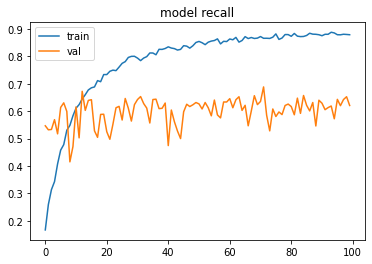

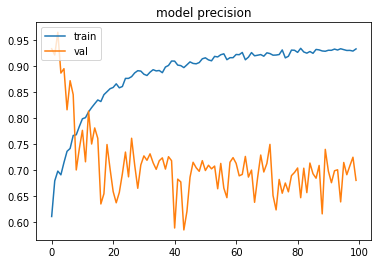

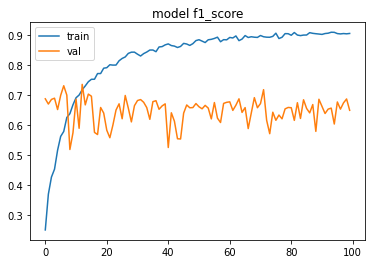

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
# plt.title('model auc')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

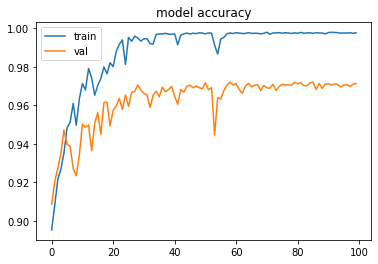

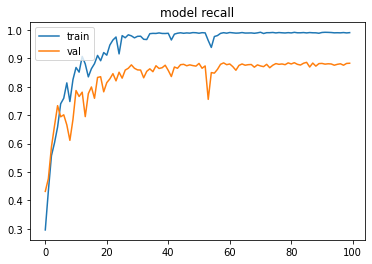

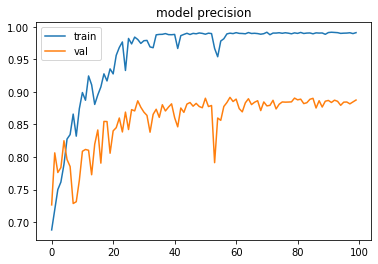

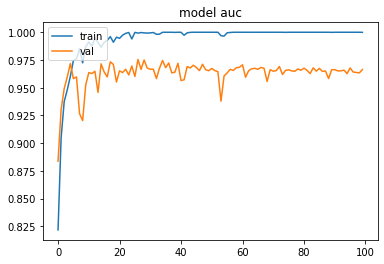

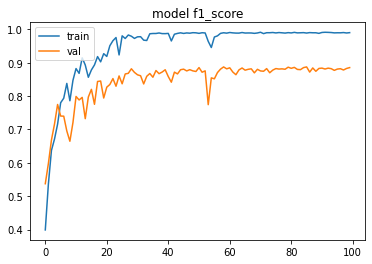

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

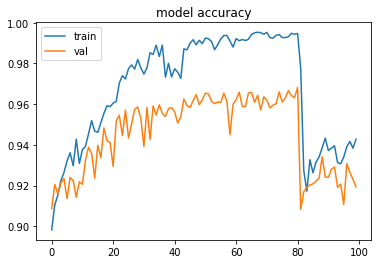

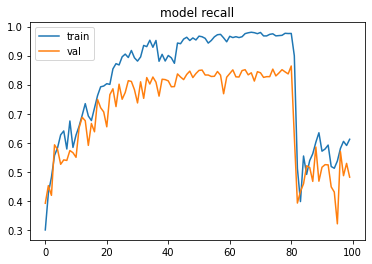

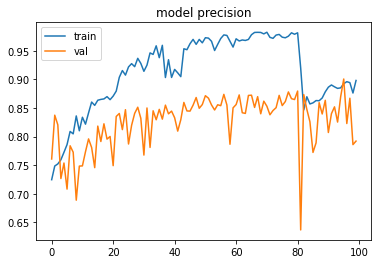

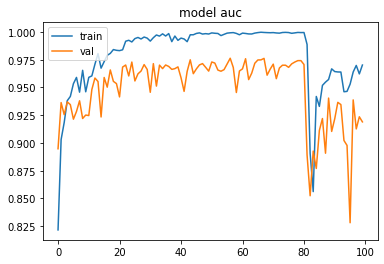

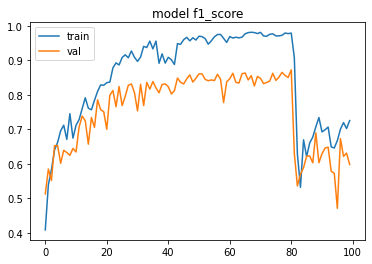

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
# plt.title('model auc')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

# Dimention reduction

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=512)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
model.fit(X_kbest, list(df.labels))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='accuracy', n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='f1_macro', n_jobs=-1)
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



Accuracy: 0.583 (0.014)
f1_macro: 0.400 (0.029)


In [ ]:

fvalue_Best = SelectKBest(f_classif, k=256)
X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
print(X_kbest.shape)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
model.fit(X_kbest, list(df.labels))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='accuracy', n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='f1_macro', n_jobs=-1)
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



(4000, 256)
Accuracy: 0.578 (0.006)
f1_macro: 0.394 (0.019)


In [ ]:

fvalue_Best = SelectKBest(f_classif, k=1024)
X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
print(X_kbest.shape)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
model.fit(X_kbest, list(df.labels))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='accuracy', n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='f1_macro', n_jobs=-1)
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



(4000, 1024)
Accuracy: 0.606 (0.003)
f1_macro: 0.435 (0.014)


In [ ]:
list(df.vecs)[0].shape #~151K

(151296,)

In [ ]:

fvalue_Best = SelectKBest(f_classif, k=10000)
X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
print(X_kbest.shape)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
model.fit(X_kbest, list(df.labels))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='accuracy', n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


n_scores = cross_val_score(model,X_kbest, list(df.labels), scoring='f1_macro', n_jobs=-1)
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



(4000, 10000)
Accuracy: 0.631 (0.016)
f1_macro: 0.476 (0.027)


In [ ]:
np.stack(df.vecs.values).shape

(4000, 151296)

In [ ]:

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(2048,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(16, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_kbest, onehot, validation_split=0.2, epochs = 500, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 gaussian_noise_9 (GaussianN  (None, 2048)             0         
 oise)                                                           
                                                                 
 dense_47 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_48 (Dense)            (None, 512)               524800    
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                      

In [ ]:

fvalue_Best = SelectKBest(f_classif, k=2048*2)
X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
print(X_kbest.shape)


(4000, 4096)


Epoch 1/500
100/100 [==============================] - 6s 30ms/step - loss: 2.4399 - precision: 0.6304 - recall: 0.1050 - f1_score: 0.1650 - val_loss: 2.3082 - val_precision: 0.7362 - val_recall: 0.1500 - val_f1_score: 0.2445
Epoch 2/500
100/100 [==============================] - 1s 6ms/step - loss: 2.2544 - precision: 0.6764 - recall: 0.2241 - f1_score: 0.3332 - val_loss: 2.2006 - val_precision: 0.6763 - val_recall: 0.2350 - val_f1_score: 0.3428
Epoch 3/500
100/100 [==============================] - 1s 6ms/step - loss: 2.1678 - precision: 0.6778 - recall: 0.2531 - f1_score: 0.3640 - val_loss: 2.1330 - val_precision: 0.6937 - val_recall: 0.2463 - val_f1_score: 0.3579
Epoch 4/500
100/100 [==============================] - 1s 7ms/step - loss: 2.1001 - precision: 0.6928 - recall: 0.2509 - f1_score: 0.3656 - val_loss: 2.0683 - val_precision: 0.6860 - val_recall: 0.2812 - val_f1_score: 0.3929
Epoch 5/500
100/100 [==============================] - 1s 6ms/step - loss: 2.0420 - precision: 0.70

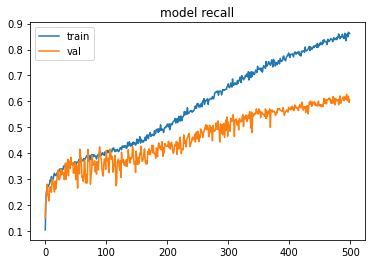

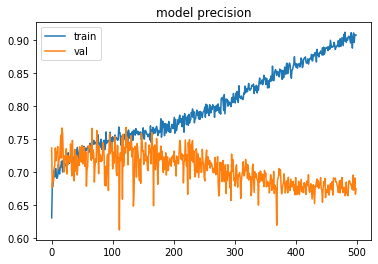

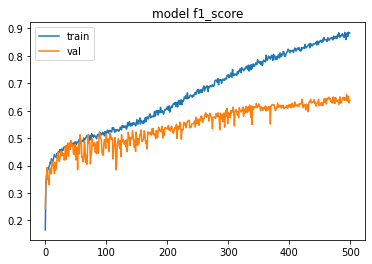

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=2048*2)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(2048*2,),))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.GaussianNoise(0.2))
# model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
# model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(16, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

# model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_kbest, onehot, validation_split=0.2, epochs = 500, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10000)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 1024)              10241024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                        

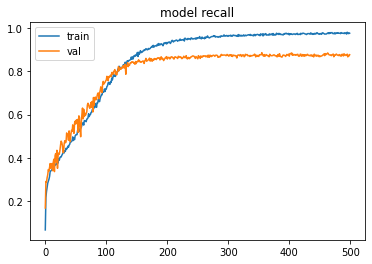

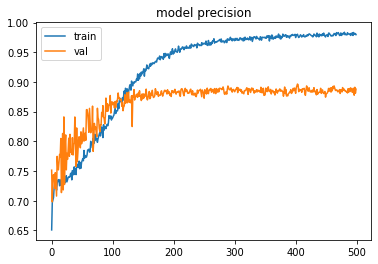

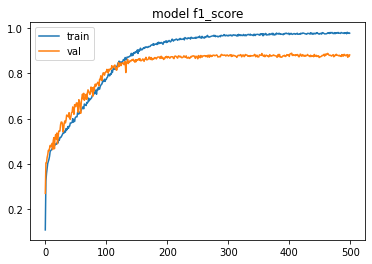

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 500, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_7 (Dense)             (None, 1024)              10241024  
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

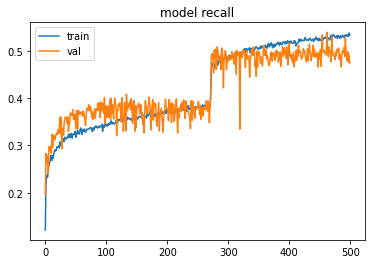

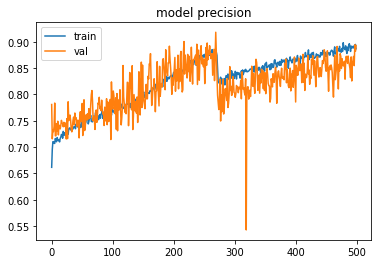

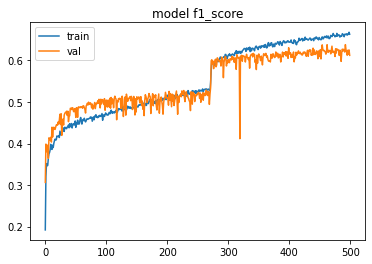

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 500, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10000)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 1024)              10241024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                      

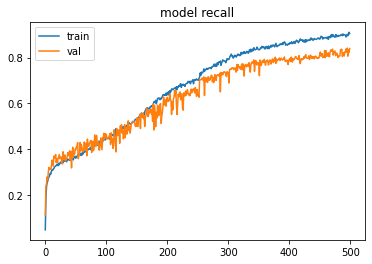

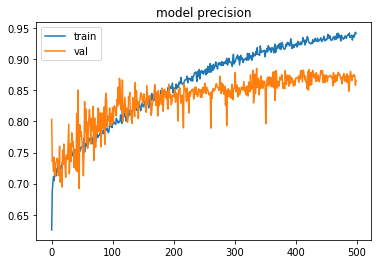

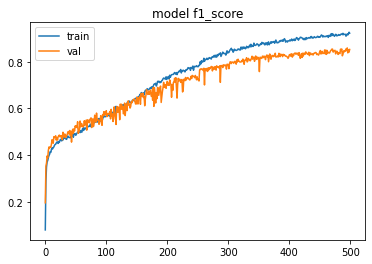

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.3, epochs = 500, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:



def build_model(hp):
  model = keras.Sequential()
  model.add(tf.keras.Input(shape=(10000,),))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.GaussianNoise(0.2))
  model.add(tf.keras.layers.Dense(hp.Choice('units', [1024, 2048]), activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.Dense(hp.Choice('units2', [512, 1024]), activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l1_l2'))
  model.add(tf.keras.layers.Dense(hp.Choice('units3', [128, 256]), activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))




  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'
  return model

tuner = kt.RandomSearch( build_model, objective= kt.Objective("val_f1_score", direction="max"), max_trials=30,overwrite=True)
tuner.search(np.stack(df.vecs.values), onehot, epochs=100, validation_split=0.3)
best_model = tuner.get_best_models()[0]
# history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
#             save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

tuner.get_best_models()
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 7 Complete [00h 03m 23s]
val_f1_score: 0.5114724040031433

Best val_f1_score So Far: 0.5184958577156067
Total elapsed time: 00h 22m 44s
INFO:tensorflow:Oracle triggered exit


{'units': 1024, 'units2': 512, 'units3': 128}

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_28 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                      

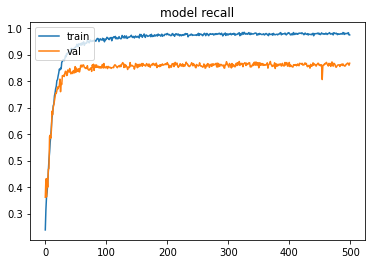

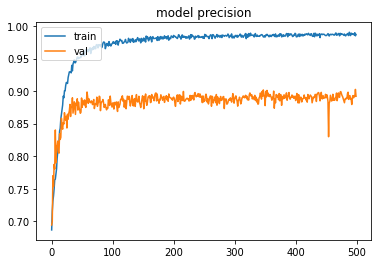

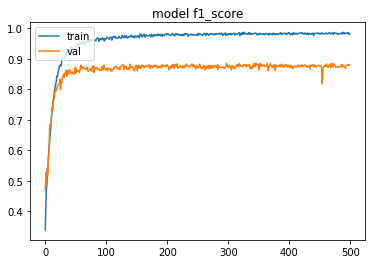

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.3, epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_6 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_40 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_41 (Dense)            (None, 512)               524800    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               65664     
                                                      

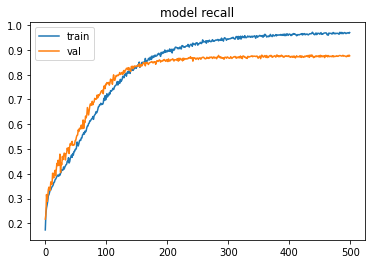

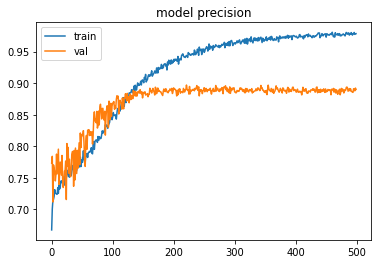

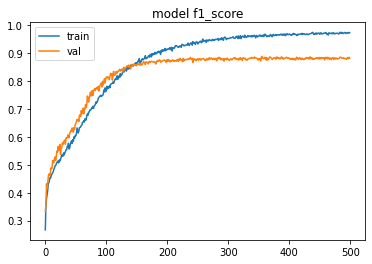

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.3, epochs = 500,batch_size=32, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.3, epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



Epoch 1/500
346/346 [==============================] - 4s 12ms/step - loss: 0.5399 - precision: 0.8679 - recall: 0.7890 - f1_score: 0.8256 - val_loss: 0.5718 - val_precision: 0.8645 - val_recall: 0.8171 - val_f1_score: 0.8404
Epoch 2/500
346/346 [==============================] - 5s 13ms/step - loss: 0.5060 - precision: 0.8771 - recall: 0.7970 - f1_score: 0.8340 - val_loss: 0.5911 - val_precision: 0.8506 - val_recall: 0.7965 - val_f1_score: 0.8227
Epoch 3/500
346/346 [==============================] - 3s 9ms/step - loss: 0.5187 - precision: 0.8703 - recall: 0.7952 - f1_score: 0.8299 - val_loss: 0.5781 - val_precision: 0.8617 - val_recall: 0.8142 - val_f1_score: 0.8373
Epoch 4/500
346/346 [==============================] - 3s 8ms/step - loss: 0.5151 - precision: 0.8757 - recall: 0.7941 - f1_score: 0.8315 - val_loss: 0.5794 - val_precision: 0.8598 - val_recall: 0.8112 - val_f1_score: 0.8346
Epoch 5/500
346/346 [==============================] - 3s 8ms/step - loss: 0.5182 - precision: 0.8

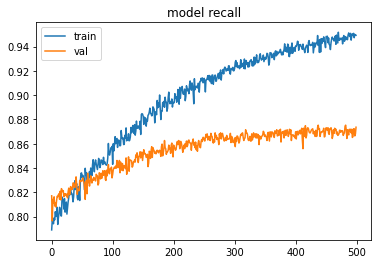

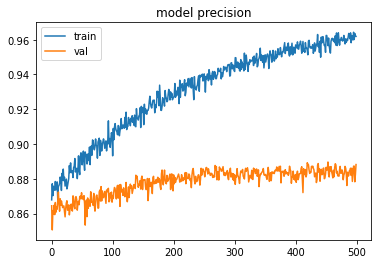

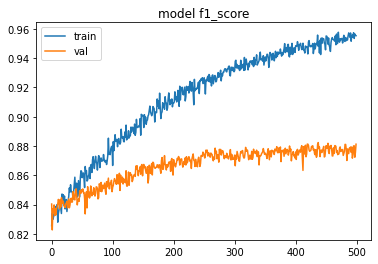

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# X_kbest
# df.vecs = X_kbest
# df.vecs.iloc[0]
# np.array(df.vecs).shape, X_kbest.shape
# df['vecs'] =  X_kbest
# np.array(df.vecs).shape
# X_kbest

fvalue_Best = SelectKBest(f_classif, k=100000)
X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
print(X_kbest.shape)

df = pd.DataFrame(data={'vecs':list(X_kbest), 'labels':df.labels })
df.to_parquet('/content/drive/MyDrive/breast_cancer_detection/vec_10k.gzip')

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# #
# # Create an instance of Pipeline
# #
# # pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
# #
# # Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
# #
# strtfdKFold = StratifiedKFold(n_splits=10)
# kfold = strtfdKFold.split(np.stack(df.vecs.values), np.stack(df.labels))
# scores = []
# #
# #
# #
# for k, (train, test) in enumerate(kfold):
#     print(k, train.shape, test.shape)
# #     pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
# #     score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
# #     scores.append(score)
# #     print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
# # print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

0 (7118,) (791,)
1 (7118,) (791,)
2 (7118,) (791,)
3 (7118,) (791,)
4 (7118,) (791,)
5 (7118,) (791,)
6 (7118,) (791,)
7 (7118,) (791,)
8 (7118,) (791,)
9 (7119,) (790,)


In [ ]:
# final
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))
model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

res = []

for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(np.stack(df.vecs.values) , onehot, test_size=0.3, random_state=40)
  print(X_train.shape), print(y_train.shape)
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs = 10,batch_size=32)

  from sklearn.metrics import classification_report
  y_true = y_test
  y_pred = model.predict(X_test)
  target_names = list(set(df.labels))
  res.append(classification_report(y_true, y_pred, target_names=target_names))


res

['6', '2', '4', '0', '7', '5', '3', '1']

In [ ]:

from sklearn.metrics import classification_report
y_true = y_test
y_pred = model.predict(X_test)
target_names = list(set(df.labels))
res.append(classification_report(y_true, y_pred, target_names=target_names))



ValueError: ignored

In [ ]:
y_test[0], y_pred[0]

from sklearn.metrics import classification_report
y_true = y_test
y_pred = model.predict(X_test)
target_names = list(set(df.labels))
y_test_classes = y_test.argmax(1)
y_pred_classes = y_pred.argmax(1)

print(classification_report(y_true=y_test_classes, y_pred=y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

           6       0.63      0.94      0.76      1041
           2       0.34      0.76      0.47       295
           4       0.27      0.09      0.13       242
           0       0.46      0.12      0.19       179
           7       0.44      0.02      0.04       170
           5       0.55      0.07      0.13       167
           3       0.00      0.00      0.00       139
           1       0.62      0.11      0.18       140

    accuracy                           0.54      2373
   macro avg       0.41      0.26      0.24      2373
weighted avg       0.49      0.54      0.44      2373



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


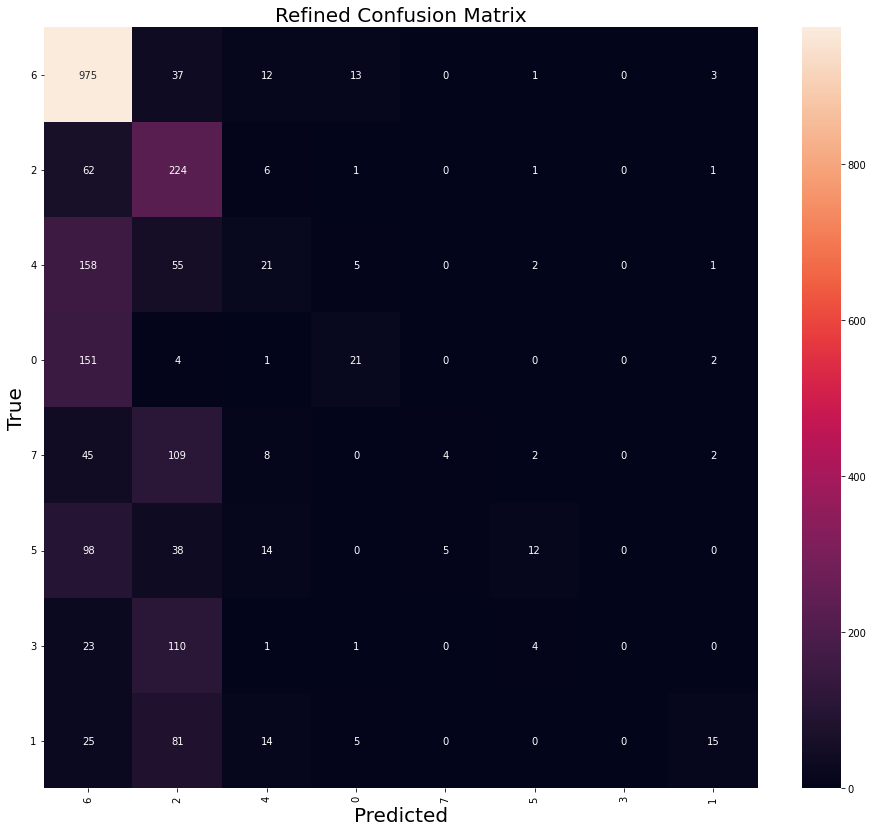

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test_classes, y_pred_classes)

## Get Class Labels
# labels = le.classes_
class_names = target_names

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

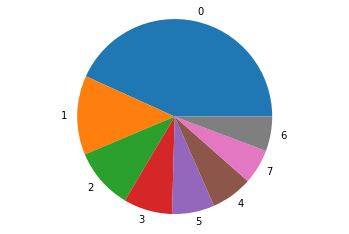

In [ ]:
labels = []
sizes = []
your_data = (dict(df['labels'].value_counts()))
for x, y in your_data.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels)

plt.axis('equal')
plt.show()

In [ ]:
# d={}
# for key in your_data:
#   d[int(key)] = your_data[key]
# print(d)

# import math

# # labels_dict : {ind_label: count_label}
# # mu : parameter to tune 

# def create_class_weight(labels_dict,mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# # random labels_dict
# labels_dict = d

# d2 = create_class_weight(labels_dict)
# d2
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 


def create_class_weight(labels_dict,mu=0.6):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    # total = sum(labels_dict.values())
    # max_num = max(labels_dict.values())
    # mu = 1.0 / (total / max_num)
    print('mu', mu)

    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# random labels_dict
labels_dict = d #{0: 2813, 1: 78, 2: 2814, 3: 78, 4: 7914, 5: 248, 6: 7914, 7: 248}

dd = create_class_weight(labels_dict)
dd

{0: 1.0,
 1: 1.5189170156541991,
 2: 1.7790700596850673,
 3: 2.003462830399709,
 4: 2.165981759897484,
 5: 2.144162712502844,
 6: 2.3490388812703924,
 7: 2.3380618226392413}

In [ ]:

your_data = (dict(data['cl2'].value_counts()))
d={}
for key in your_data:
  d[int(key)] = your_data[key]
print(d)

def create_class_weight(labels_dict,mu=0.6):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1.0 / (total / max_num)
    print('mu', mu)

    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# random labels_dict
labels_dict = d #{0: 2813, 1: 78, 2: 2814, 3: 78, 4: 7914, 5: 248, 6: 7914, 7: 248}

dd = create_class_weight(labels_dict)
dd

{0: 3451, 1: 1014, 2: 792, 3: 626, 4: 569, 5: 560, 6: 453, 7: 444}
mu 0.4363383487166519


{0: 1.0,
 1: 1.2247611389468749,
 2: 1.4718579312835776,
 3: 1.7070689519979048,
 4: 1.8025388889716725,
 5: 1.8184825393688084,
 6: 2.0305271976149695,
 7: 2.0505947606657786}

In [ ]:
your_data

{'0': 3418,
 '1': 1039,
 '2': 801,
 '3': 640,
 '4': 544,
 '5': 556,
 '6': 453,
 '7': 458}

In [ ]:
df.labels


3573    0
620     1
7243    3
5978    4
6219    0
       ..
1324    4
6753    0
6878    0
1388    4
5115    7
Name: labels, Length: 7909, dtype: object

In [ ]:
onehot[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced', list(set(df['labels'])), list(df['labels'])) 
classes_weights = class_weight.compute_sample_weight( class_weight='balanced', y=list(df['labels']))
len(classes_weights)

7909

(5536, 10000)
(5536, 8)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_15 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_5 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_25 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               65664     
                              

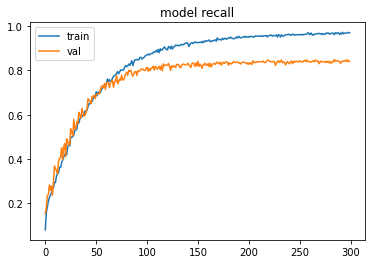

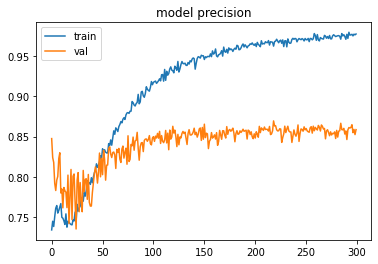

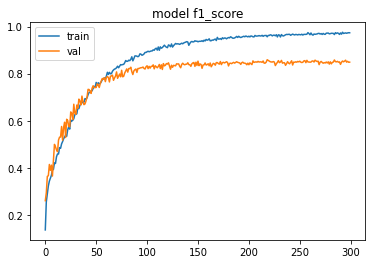

In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

X_train, x_test, y_train, y_test = train_test_split(np.stack(df.vecs.values) , onehot, test_size=0.3, random_state=40)
print(X_train.shape), print(y_train.shape)

# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                    list(set(df['labels'])), list(df['labels']))

# print(class_weights)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs = 300,batch_size=32,class_weight=dd)#,class_weight=classWeight)#, batch_size = 32)



from sklearn.metrics import classification_report
y_true = y_test
y_pred = model.predict(x_test)
target_names = list(set(df.labels))
y_test_classes = y_test.argmax(1)
y_pred_classes = y_pred.argmax(1)

print(classification_report(y_true=y_test_classes, y_pred=y_pred_classes, target_names=target_names))





plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# DenseNet169 

In [ ]:
# import numpy as np
# import keras

# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
#                  n_classes=10, shuffle=True,filters=None):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_augmentation(self, img):
#         ''' function for apply some data augmentation '''
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
        
#         return img

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size,*self.dim))#3,224,224))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
            
#             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
#             img = img_to_array(img)#,data_format='channels_first')
#             img = tf.keras.applications.densenet.preprocess_input(img)
#             img = self.__data_augmentation(img)

#             X[i,] = np.expand_dims(img, axis=0)

#             y[i] = self.labels[ID]
#         return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

# import numpy as np

# from keras.models import Sequential
# n_classes = len(set(data.cl2))
# params = {'dim': (224,224,3),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
#           'batch_size': 32,# 512,# 128,
#           'n_classes':n_classes,#962,
# #           'n_channels': 1,
#           'shuffle': True,}

# im_dir='/content/drive/MyDrive/breast_cancer_detection/BreaKHis_v1/'
# partition={'train': list(data.path[:int(0.7*len(data))]),
#            'validation': list(data.path[int(0.7*len(data)):])}
# # labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
# labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']
# # Generators
# training_generator = DataGenerator(partition['train'], labels, **params)
# validation_generator = DataGenerator(partition['validation'], labels, **params)

# for ind,row in validation_generator:
#     print(ind.shape,row.shape)
#     break

(32, 224, 224, 3) (32, 8)


8

In [ ]:
# # batch size 32:
# # with augmentation

# # with pre processing 
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False
# for layer in basemodel.layers[:-10]:
#     layer.trainable = True

# model= tf.keras.Sequential()
# # model.add(Input(shape=(224,224,3)))
# # model.add()
# model.add(basemodel)
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.25))


# # model.add(tf.keras.layers.Dense(1024,activation='relu',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.add(tf.keras.layers.Dense(n_classes, activation='softmax',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.summary()



# your_data = (dict(data['cl2'].value_counts()))
# d={}
# for key in your_data:
#   d[int(key)] = your_data[key]
# print(d)

# def create_class_weight(labels_dict,mu=0.6):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     total = sum(labels_dict.values())
#     max_num = max(labels_dict.values())
#     mu = 1.0 / (total / max_num)
#     print('mu', mu)

    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# # random labels_dict
# labels_dict = d 
# dd = create_class_weight(labels_dict)


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# # opt = tf.keras.optimizers.Adam(lr=0.001)

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# history = model.fit(training_generator, validation_data=validation_generator, epochs = 50,class_weight=dd)#, batch_size = 32)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten_1 (Flatten)         (None, 1664)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1664)             6656      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 1664)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 8)                 13320     
                                                      

KeyboardInterrupt: ignored

In [ ]:
# final binary

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)


X_train, x_test, y_train, y_test = train_test_split(np.stack(df.vecs.values) , onehot, test_size=0.3, random_state=40)
print(X_train.shape), print(y_train.shape)


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'



history = model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs = 300,batch_size=16)#,class_weight=dd)#,class_weight=classWeight)#, batch_size = 32)



from sklearn.metrics import classification_report
y_true = y_test
y_pred = model.predict(x_test)
target_names = list(set(df.labels))
y_test_classes = y_test.argmax(1)
y_pred_classes = y_pred.argmax(1)

print(classification_report(y_true=y_test_classes, y_pred=y_pred_classes, target_names=target_names))





plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.3, epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
#             save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])
# plt.title('model recall')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# plt.plot(history.history['precision'])
# plt.plot(history.history['val_precision'])
# plt.title('model precision')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# plt.plot(history.history['f1_score'])
# plt.plot(history.history['val_f1_score'])
# plt.title('model f1_score')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

(5536, 10000)
(5536, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_5 (Dense)             (None, 1024)              10241024  
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                              

TypeError: ignored

In [ ]:
print(classification_report(y_true=y_test_classes, y_pred=y_pred_classes, target_names=['a','b']))


              precision    recall  f1-score   support

           a       0.92      0.91      0.91       749
           b       0.96      0.96      0.96      1624

    accuracy                           0.95      2373
   macro avg       0.94      0.94      0.94      2373
weighted avg       0.95      0.95      0.95      2373



In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(151296,),))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.GaussianNoise(0.2))
# model.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
# model.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))#, kernel_regularizer='l1_l2')),
# # model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

# model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      # tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


def build_model(hp):
  model = keras.Sequential()
  model.add(tf.keras.Input(shape=(10000,),))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.GaussianNoise(0.3))
  model.add(tf.keras.layers.Dense(hp.Choice('units', [256, 512,1028]), activation='relu'))#, kernel_regularizer='l1'))
  model.add(tf.keras.layers.Dense(hp.Choice('units2', [64, 128, 256,512]), activation='relu'))#, kernel_regularizer='l1_l2')),
  model.add(tf.keras.layers.Dense(hp.Choice('units3', [16, 128, 256]), activation='relu'))#, kernel_regularizer='l1_l2')),
  # model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01),activity_regularizer= tf.keras.regularizers.l1(0.01))),
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax'))
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'
  return model

tuner = kt.RandomSearch( build_model, objective= kt.Objective("val_f1_score", direction="max"), max_trials=30,overwrite=True)
tuner.search(np.stack(df.vecs.values), onehot, epochs=60, validation_split=0.3)
best_model = tuner.get_best_models()[0]
# history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
#             save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

tuner.get_best_models()
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values


Trial 30 Complete [00h 01m 22s]
val_f1_score: 0.9270833134651184

Best val_f1_score So Far: 0.9302500486373901
Total elapsed time: 00h 44m 34s
INFO:tensorflow:Oracle triggered exit


{'units': 512, 'units2': 64, 'units3': 128}